# Time Series Analysis, Time Series Forecasting, and Neural Networks

This notebook provides a comprehensive introduction to time series analysis and forecasting. We will cover the following topics:

1.  **Stationarity in Time Series**
    * What is Stationarity?
    * Visual Indicators of Stationarity
    * Statistical Tests of Stationarity (Augmented Dickey-Fuller Test)
2.  **Forecasting Techniques**
    * Exponential Smoothing (Simple, Double, and Triple)
    * ARIMA
    * SARIMA
    * LSTM Neural Networks
3.  **Model Comparison**
4.  **Saving Predictions**

## 1. Stationarity in Time Series

### What is Stationarity?

A time series is said to be **stationary** if its statistical properties such as mean, variance, and autocorrelation are constant over time. Most time series models require the data to be stationary. If the time series is not stationary, we need to transform it to a stationary series before we can apply the models.

A stationary time series has the following properties:

* **Constant Mean:** The mean of the series is constant over time.
* **Constant Variance:** The variance of the series is constant over time.
* **Constant Autocorrelation:** The autocorrelation of the series is constant over time.

### Visual Indicators of Stationarity

We can visually inspect a time series plot to get an idea of whether it is stationary or not. Here are some visual cues:

* The mean of the series should be constant. If there is a trend (upward or downward), the mean is not constant, and the series is not stationary.
* The variance of the series should be constant. If the spread of the data changes over time, the variance is not constant, and the series is not stationary.
* There should be no seasonal patterns.

Let's load our data and visualize it to check for stationarity.

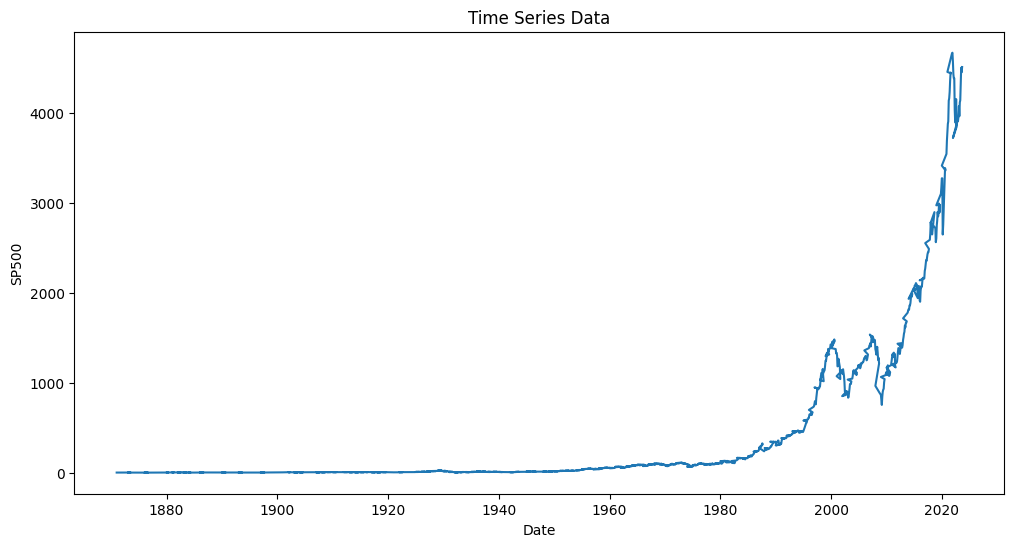

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
# Make sure to upload your SP500Index.csv file to the Colab environment
url = 'https://github.com/course-files/TimeSeriesForecastingandNeuralNetworks/raw/refs/heads/main/data/SP500Index.csv'
df = pd.read_csv(url)

# Corrected the column name from 'Value' to 'SP500'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
time_series = df['SP500']

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(time_series)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('SP500')
plt.show()

### Decomposing Time Series
Decomposing a time series helps us understand its components: trend, seasonality, and residuals (or irregular component). This can provide insights into the underlying patterns in the data.
We can use the `seasonal_decompose` function from `statsmodels` to decompose the time series. The decomposition can be either additive or multiplicative.
- **Additive Decomposition:** The time series is expressed as the sum of its components: `Y(t) = Trend(t) + Seasonality(t) + Residual(t)`
- **Multiplicative Decomposition:** The time series is expressed as the product of its components: `Y(t) = Trend(t) * Seasonality(t) * Residual(t)`
- **Trend:** The long-term movement in the data.
- **Seasonality:** The repeating short-term cycle in the data.
- **Residual:** The random noise or irregular component in the data that cannot be explained by the trend or seasonality.
- **Cycle:** A long-term oscillation in the data that is not necessarily seasonal. It can be thought of as a longer-term trend that fluctuates around a mean value.
- **Note:** The cycle is often included in the residual if the decomposition is additive, as it captures long-term fluctuations that are not seasonal.

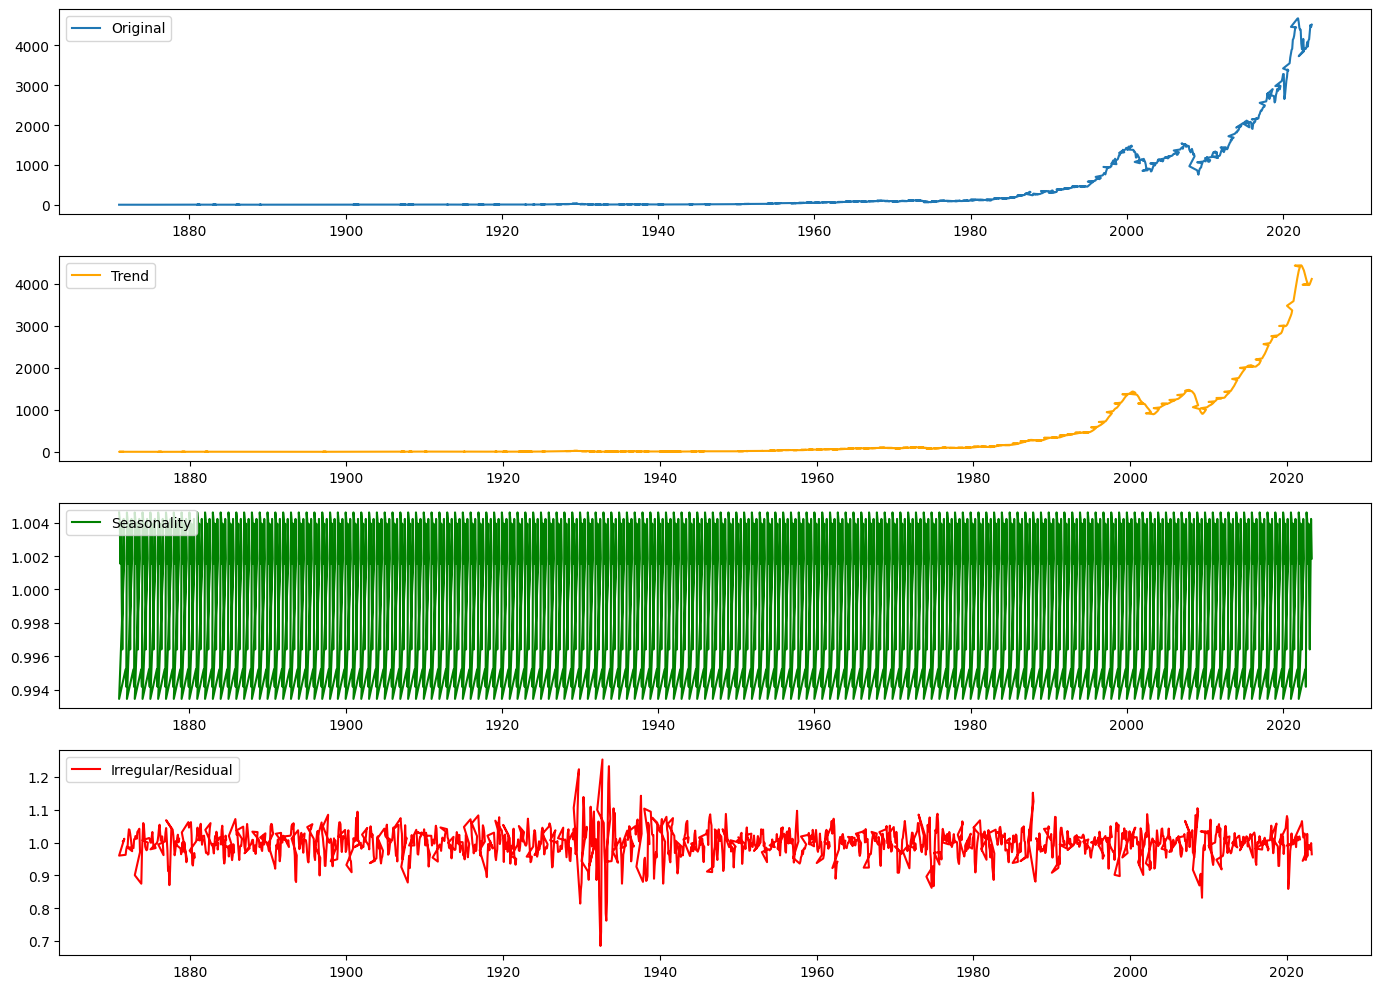

In [67]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (use model='additive' or 'multiplicative' as appropriate)
decomposition = seasonal_decompose(time_series, model='multiplicative', period=12)

# Plot the components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(time_series, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Irregular/Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Statistical Tests of Stationarity

Visual inspection can be subjective. Therefore, we use statistical tests to check for stationarity. One of the most commonly used tests is the **Augmented Dickey-Fuller (ADF) test**.

The ADF test is a statistical test that tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is that the time series is stationary.

* **Null Hypothesis (H0):** The time series is non-stationary.
* **Alternative Hypothesis (H1):** The time series is stationary.

We interpret the result of the ADF test using the p-value. If the p-value is less than a significance level (e.g., 0.05), we reject the null hypothesis and conclude that the time series is stationary.

In [68]:
def adf_test(series):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

adf_test(time_series)

ADF Statistic: 8.184238226288024
p-value: 1.0
Critial Values:
   1%, -3.433968010099092
Critial Values:
   5%, -2.8631381499714745
Critial Values:
   10%, -2.567620802173316


If the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that the time series is non-stationary. In this case, we need to make the series stationary. A common way to do this is by **differencing** the series.

### Data Transformation (Stationarizing Techniques)

#### Differencing: Taking first differences `(X(t) - X(t-1))`

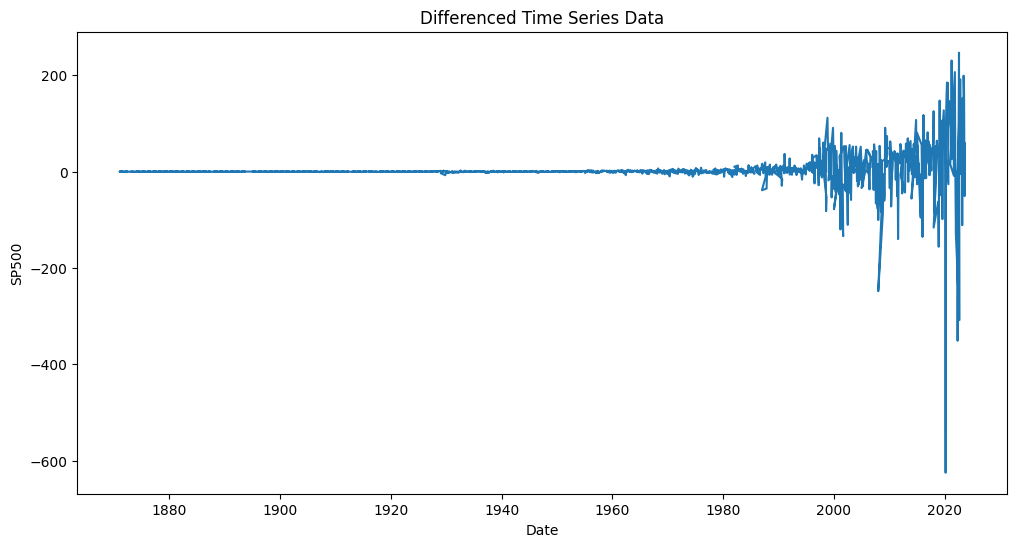

ADF Statistic: -6.3391622012923445
p-value: 2.7822123486924075e-08
Critial Values:
   1%, -3.433976034843506
Critial Values:
   5%, -2.8631416925158244
Critial Values:
   10%, -2.5676226884667694


In [69]:
# If the series is non-stationary, we can difference it
time_series_diff = time_series.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(time_series_diff)
plt.title('Differenced Time Series Data')
plt.xlabel('Date')
plt.ylabel('SP500')
plt.show()

# Perform ADF test on the differenced series
adf_test(time_series_diff)

#### Detrending: Removing trend components

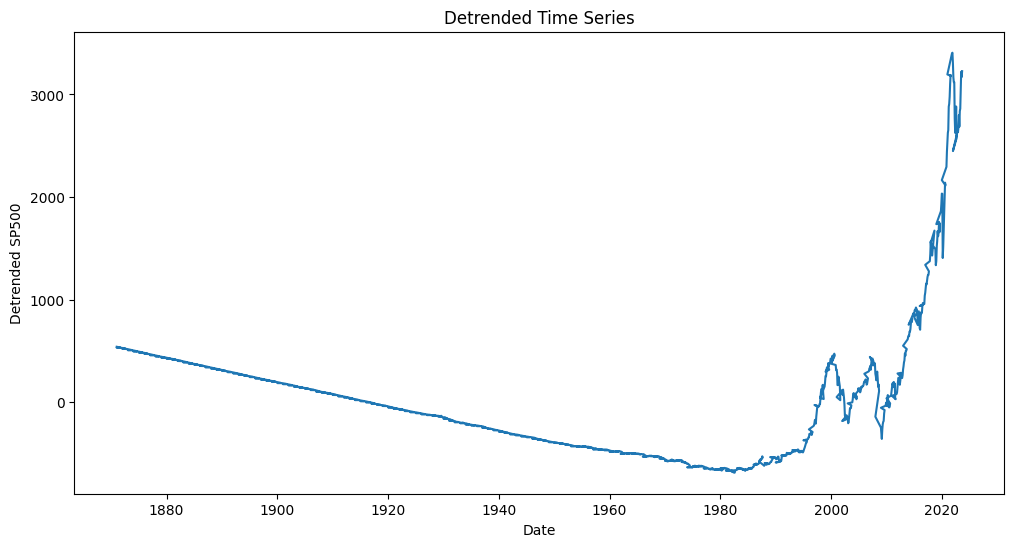

ADF Statistic: 4.238245833959746
p-value: 1.0
Critial Values:
   1%, -3.433972018026501
Critial Values:
   5%, -2.8631399192826676
Critial Values:
   10%, -2.5676217442756872


In [70]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare the time index as a feature for regression
time_index = np.arange(len(time_series)).reshape(-1, 1)

# Fit linear regression (trend)
lr = LinearRegression()
lr.fit(time_index, time_series.values)
trend = lr.predict(time_index)

# Detrend the series
detrended_series = time_series.values - trend

# Plot the detrended series
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, detrended_series)
plt.title('Detrended Time Series')
plt.xlabel('Date')
plt.ylabel('Detrended SP500')
plt.show()

adf_test(detrended_series)

#### Log transformation: For changing variance

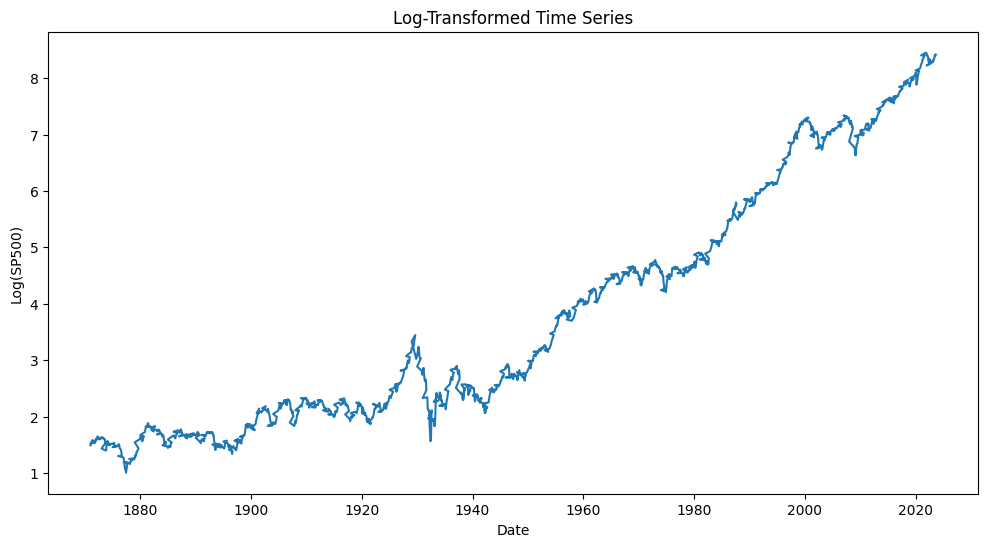

ADF Statistic: 1.4734995686648467
p-value: 0.9974237482470721
Critial Values:
   1%, -3.433966009459769
Critial Values:
   5%, -2.8631372667825503
Critial Values:
   10%, -2.567620331903232


In [71]:
import numpy as np

# Apply log transformation (add a small constant if data contains zeros)
log_time_series = np.log(time_series + 1e-8)

# Plot the log-transformed series
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, log_time_series)
plt.title('Log-Transformed Time Series')
plt.xlabel('Date')
plt.ylabel('Log(SP500)')
plt.show()

adf_test(log_time_series)

#### Seasonal differencing: For seasonal patterns

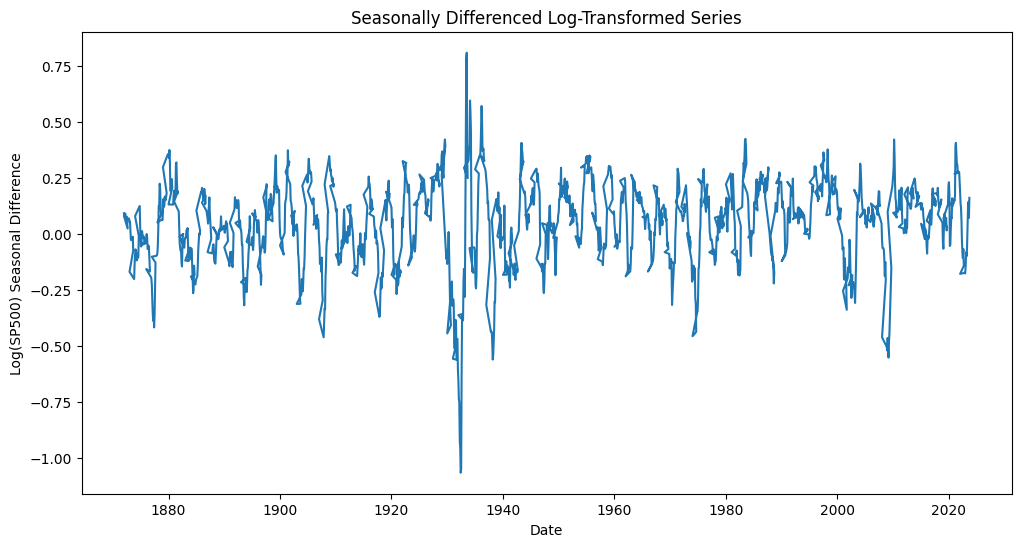

ADF Statistic: -6.551378800849226
p-value: 8.833521652808024e-09
Critial Values:
   1%, -3.4339982875683357
Critial Values:
   5%, -2.863151515989605
Critial Values:
   10%, -2.567627919165742


In [72]:
# Seasonal differencing (e.g., period=12 for monthly data)
seasonal_diff_log = log_time_series.diff(12).dropna()

plt.figure(figsize=(12, 6))
plt.plot(seasonal_diff_log)
plt.title('Seasonally Differenced Log-Transformed Series')
plt.xlabel('Date')
plt.ylabel('Log(SP500) Seasonal Difference')
plt.show()

adf_test(seasonal_diff_log)

### In-Built Stationarizing Mechanism in Models
1. **❌Exponential Smoothing (Simple, Double [Holt], and Triple [Holt-Winters])**
- Exponential Smoothing techniques do not require the series to be stationary.
- Instead, they explicitly model components such as trend and seasonality directly.
- They handle non-stationarity by design, rather than transforming the data to a stationary form.

2. **✅ARIMA (AutoRegressive Integrated Moving Average)**
- ARIMA explicitly includes differencing (the "I" in ARIMA) as part of the model to make the series stationary.
- You specify the `d` parameter in `ARIMA(p, d, q)`, where:
  - `d = 1` tells the model to difference the data once. This step transforms a non-stationary series into a stationary one internally.

3. **✅SARIMA (Seasonal ARIMA)**
- SARIMA extends ARIMA with seasonal differencing.
- It uses two differencing parameters:
  - `d` for non-seasonal differencing,
  - `D` for seasonal differencing over a defined period m.
- Therefore, SARIMA also has built-in mechanisms to induce both stationarity and seasonal stationarity.

4. **❌LSTM (Long Short-Term Memory Networks)**
- LSTM models do not have explicit stationarizing mechanisms.
- They learn directly from raw sequences, even if they are non-stationary.
- However, data preprocessing such as normalization and differencing often improves performance.
- LSTMs can model complex non-linear and non-stationary behavior, but they do not automatically make the data stationary.

## 2. Time Series Forecasting Techniques

### Exponential Smoothing

Exponential smoothing is a time series forecasting method for univariate data. It is a weighted average of past observations, with the weights decaying exponentially as the observations get older.

**Note:** Unlike ARIMA models, some exponential smoothing models are designed to handle non-stationary data directly by explicitly modeling trend and seasonality. This is why we can apply them to the original time series.

#### Simple Exponential Smoothing (SES)

SES is suitable for time series data with no trend or seasonality.

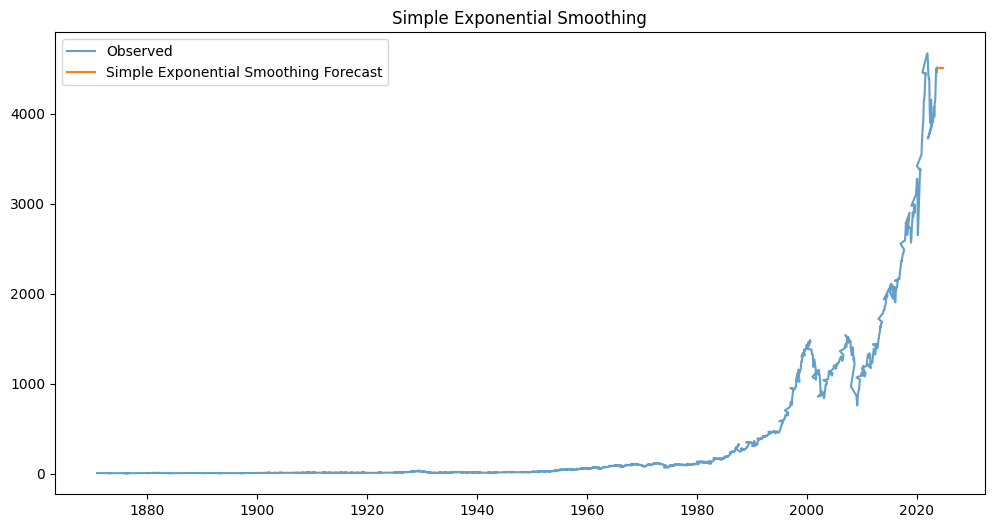

In [90]:
model_ses = SimpleExpSmoothing(time_series, initialization_method="estimated").fit()
predictions_ses = model_ses.forecast(12) # forecast for next 12 months

future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M')
predictions_ses = pd.Series(predictions_ses.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed', alpha=0.7)
plt.plot(predictions_ses, label='Simple Exponential Smoothing Forecast')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

#### Double Exponential Smoothing (Holt's Method)

Holt's method is an extension of SES that can handle time series data with a trend.

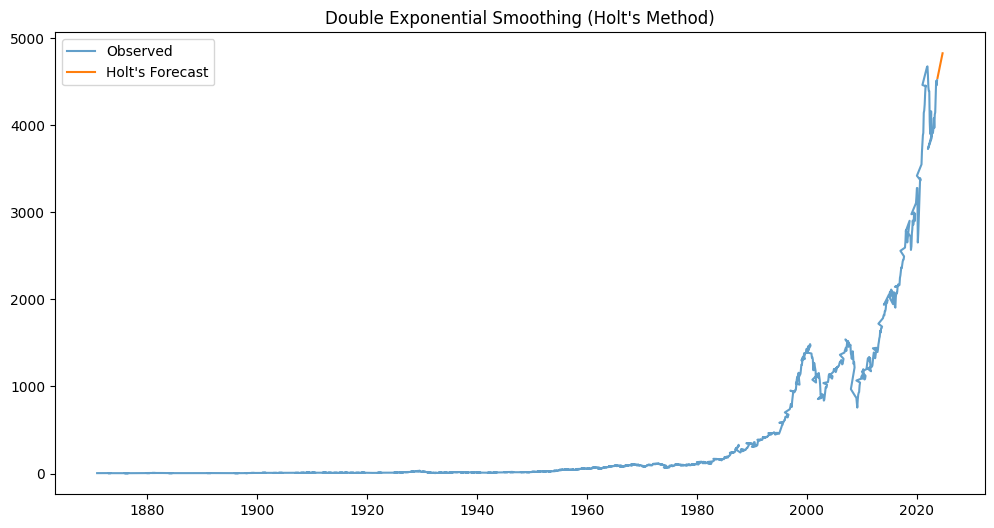

In [91]:
model_holt = Holt(time_series, initialization_method="estimated").fit()
predictions_holt = model_holt.forecast(12)

future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M')
predictions_holt = pd.Series(predictions_holt.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed', alpha=0.7)
plt.plot(predictions_holt, label='Holt\'s Forecast')
plt.title('Double Exponential Smoothing (Holt\'s Method)')
plt.legend()
plt.show()

#### Triple Exponential Smoothing (Holt-Winters Method)

The Holt-Winters method extends Holt's method to capture seasonality.

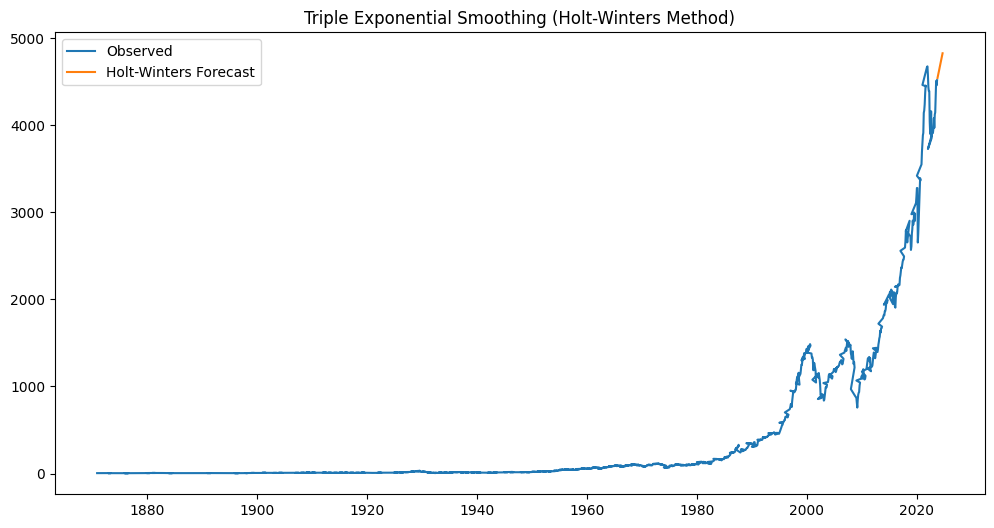

In [92]:
# Assuming a seasonal period of 12 for monthly data. Change if your data has a different seasonal period.
model_hw = ExponentialSmoothing(time_series, seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated").fit()
predictions_hw = model_hw.forecast(12)

future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M')
predictions_hw = pd.Series(predictions_holt.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(predictions_hw, label='Holt-Winters Forecast')
plt.title('Triple Exponential Smoothing (Holt-Winters Method)')
plt.legend()
plt.show()

### ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors.

An ARIMA model is characterized by 3 parameters: (p, d, q).

* **p:** The number of lag observations included in the model (lag order).
* **d:** The number of times that the raw observations are differenced (degree of differencing).
* **q:** The size of the moving average window (order of moving average).

**Important Note:** You might wonder why we are using the original `time_series` which is non-stationary. The `statsmodels` implementation of ARIMA is smart. The `d` parameter in the `order=(p,d,q)` argument tells the model how many times to difference the data. So, the model takes care of the differencing internally. This is the standard and recommended way to use ARIMA models in `statsmodels`, as it simplifies the process and automatically returns the forecasts on the original scale.

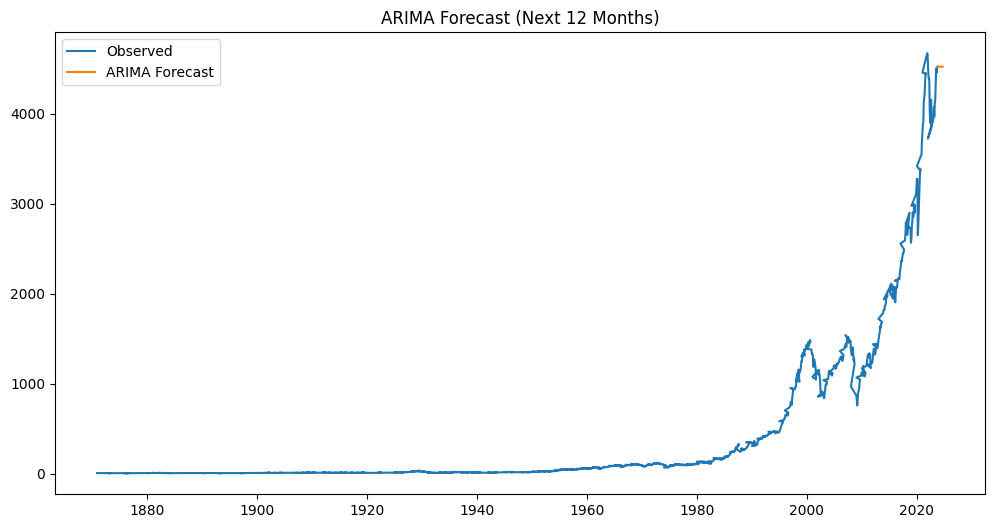

In [93]:
# Forecast the next 12 months using ARIMA
model_arima = ARIMA(time_series, order=(1, 1, 1)).fit()
predictions_arima = model_arima.forecast(steps=12)

# Create a future index for the next 12 months
future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M'
)
predictions_arima = pd.Series(predictions_arima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(predictions_arima, label='ARIMA Forecast')
plt.title('ARIMA Forecast (Next 12 Months)')
plt.legend()
plt.show()

### SARIMA

SARIMA (Seasonal ARIMA) is an extension of ARIMA that supports time series data with a seasonal component.

A SARIMA model is characterized by 7 parameters: (p, d, q) x (P, D, Q, m).

* **(p, d, q):** The non-seasonal parameters of the ARIMA model.
* **(P, D, Q, m):** The seasonal parameters of the model, where 'm' is the number of time steps for a single seasonal period.

Just like with ARIMA, we use the original time series here and let the model handle the differencing (both seasonal and non-seasonal) for us via the `d` and `D` parameters.

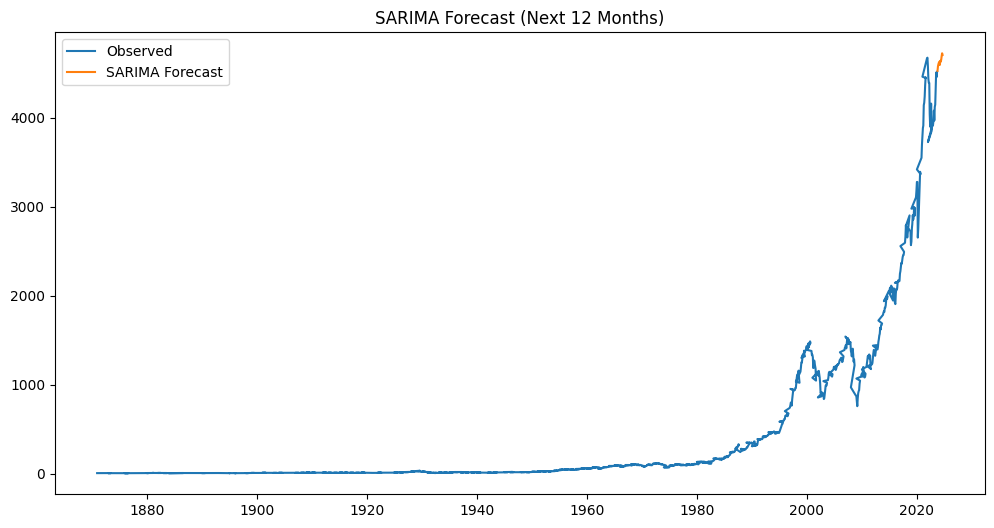

In [94]:
# Forecast the next 12 months using SARIMA
model_sarima = SARIMAX(time_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
predictions_sarima = model_sarima.forecast(steps=12)

# Create a future index for the next 12 months
future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M'
)
predictions_sarima = pd.Series(predictions_sarima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(predictions_sarima, label='SARIMA Forecast')
plt.title('SARIMA Forecast (Next 12 Months)')
plt.legend()
plt.show()

### LSTM Neural Network
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) capable of learning long-term dependencies in sequence data. They are well suited for time series forecasting tasks because they can capture both short- and long-term temporal patterns.

**Stationarity Requirement:** LSTM models do not strictly require the data to be stationary because they learn patterns directly from the raw sequences. However, it is recommended to scale the data and to remove strong trends or seasonality (for example, via differencing or decomposition) to improve convergence and predictive performance.

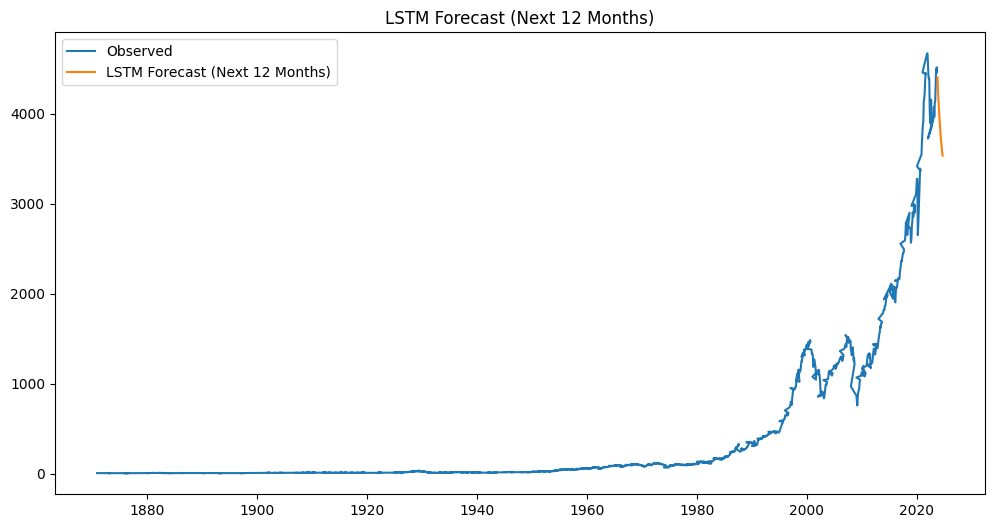

In [95]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(time_series.values.reshape(-1, 1))

def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(scaled_series, window_size)
train_size = len(X) - 12
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Forecast the next 12 months
last_sequence = scaled_series[-window_size:].reshape(1, window_size, 1)
future_predictions_scaled = []
for _ in range(12):
    next_pred = model_lstm.predict(last_sequence, verbose=0)
    future_predictions_scaled.append(next_pred[0, 0])
    last_sequence = np.concatenate(
        [last_sequence[:, 1:, :], next_pred.reshape(1, 1, 1)],
        axis=1
    )

future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1)).flatten()

# Create future index for the next 12 months
future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M'
)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(future_index, future_predictions, label='LSTM Forecast (Next 12 Months)')
plt.title('LSTM Forecast (Next 12 Months)')
plt.legend()
plt.show()

### LSTM Neural Network (Hyperparameter Tuning)
Analyze why the LSTM model is performing poorly compared to other models for time series forecasting, despite reducing the prediction horizon to 12 months. Investigate potential issues with data preparation, model hyperparameters, and evaluation methods. Implement improvements to the LSTM model and compare its performance quantitatively against other models to make it the best performer.

#### Review data preparation for lstm

##### Subtask:
Examine the scaling and sequence creation steps to ensure they are correctly implemented for the LSTM model.


**Reasoning**:
Reviewing the provided code cell for LSTM data preparation to verify scaling, sequence creation, splitting, and reshaping.



In [98]:
# Review the data preparation steps for LSTM

# 1. Verify that the MinMaxScaler is applied correctly to the time_series data.
# The scaler is fitted and transformed on the entire time_series data.
# This is correct as the scaling should be based on the overall distribution.
print("Shape of original time_series:", time_series.shape)
print("Shape of scaled_series:", scaled_series.shape)

# 2. Examine the create_sequences function.
# It iterates through the data, creating sequences of length window_size
# and the next value as the target. This looks correct.
def create_sequences_review(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

X_review, y_review = create_sequences_review(scaled_series, window_size)
print("\nShape of X created by create_sequences:", X_review.shape)
print("Shape of y created by create_sequences:", y_review.shape)
print("First sequence (X[0]):", X_review[0][:5]) # print first 5 elements of first sequence
print("First target (y[0]):", y_review[0])

# 3. Confirm that the training and testing sets are split appropriately.
# train_size is calculated to leave the last 12 months for testing.
# X_train, X_test, y_train, y_test are split based on train_size.
# This split prevents data leakage as the test set contains the last 'window_size' samples,
# which are used for forecasting the next 12 months.
print("\nLength of X before splitting:", len(X))
print("Train size calculated:", train_size)
print("Length of X_train:", len(X_train))
print("Length of X_test:", len(X_test))
print("Length of y_train:", len(y_train))
print("Length of y_test:", len(y_test))

# Check if the split is correct: X_train + X_test should equal X
print("Length of X_train + Length of X_test:", len(X_train) + len(X_test))


# 4. Check that the input data for the LSTM (X_train, X_test) is reshaped.
# X_train and X_test are reshaped to (samples, time_steps, features).
# The original sequence is 1D (window_size,), reshaped to 3D (samples, window_size, 1). This is correct.
print("\nShape of X_train after reshaping:", X_train.shape)
print("Shape of X_test after reshaping:", X_test.shape)

Shape of original time_series: (1833,)
Shape of scaled_series: (1833, 1)

Shape of X created by create_sequences: (1821, 12)
Shape of y created by create_sequences: (1821,)
First sequence (X[0]): [0.00036601 0.00037885 0.00040239 0.00043022 0.0004559 ]
First target (y[0]): 0.0004559033648314627

Length of X before splitting: 1821
Train size calculated: 1809
Length of X_train: 1809
Length of X_test: 12
Length of y_train: 1809
Length of y_test: 12
Length of X_train + Length of X_test: 1821

Shape of X_train after reshaping: (1809, 12, 1)
Shape of X_test after reshaping: (12, 12, 1)


#### Tune lstm hyperparameters

##### Subtask:
Experiment with different LSTM model architectures, layer sizes, activation functions, learning rates, epochs, and batch sizes.


**Reasoning**:
Define a function to create and train an LSTM model with configurable hyperparameters and then experiment with different hyperparameter values to train various models and forecast the next 12 months.



In [99]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(time_series.values.reshape(-1, 1))

def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(scaled_series, window_size)
train_size = len(X) - 12 # Leave the last 12 for testing/forecasting
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

def build_and_train_lstm(lstm_units, learning_rate, epochs, batch_size, X_train, y_train, window_size):
    """Build, compile, train, and return an LSTM model with given hyperparameters."""
    model = Sequential([
        LSTM(lstm_units, activation='tanh', input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)
    return model, history

def forecast_lstm(model, last_sequence, n_steps, scaler):
    """Forecast future values using a trained LSTM model."""
    future_predictions_scaled = []
    current_sequence = last_sequence.copy()
    for _ in range(n_steps):
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions_scaled.append(next_pred[0, 0])
        current_sequence = np.concatenate(
            [current_sequence[:, 1:, :], next_pred.reshape(1, 1, 1)],
            axis=1
        )
    future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1)).flatten()
    return future_predictions

# Experiment with different hyperparameters
hyperparameter_configs = [
    {'lstm_units': 30, 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 16},
    {'lstm_units': 70, 'learning_rate': 0.005, 'epochs': 75, 'batch_size': 32},
    {'lstm_units': 100, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64},
    {'lstm_units': 50, 'learning_rate': 0.01, 'epochs': 75, 'batch_size': 32}, # Another config
    {'lstm_units': 80, 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 16}  # Another config
]

lstm_forecasts = {}
last_sequence_train = scaled_series[train_size - window_size : train_size].reshape(1, window_size, 1)


for config in hyperparameter_configs:
    print(f"Training with config: {config}")
    model, history = build_and_train_lstm(
        config['lstm_units'],
        config['learning_rate'],
        config['epochs'],
        config['batch_size'],
        X_train,
        y_train,
        window_size
    )

    # Forecast the next 12 months
    future_predictions = forecast_lstm(model, last_sequence_train, 12, scaler)

    # Store forecast
    config_name = f"LSTM_units={config['lstm_units']}_lr={config['learning_rate']}_epochs={config['epochs']}_batch={config['batch_size']}"
    lstm_forecasts[config_name] = future_predictions

# Display the collected forecasts
future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M'
)

lstm_forecasts_df = pd.DataFrame(lstm_forecasts, index=future_index)
display(lstm_forecasts_df)

Training with config: {'lstm_units': 30, 'learning_rate': 0.01, 'epochs': 50, 'batch_size': 16}
Training with config: {'lstm_units': 70, 'learning_rate': 0.005, 'epochs': 75, 'batch_size': 32}
Training with config: {'lstm_units': 100, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 64}
Training with config: {'lstm_units': 50, 'learning_rate': 0.01, 'epochs': 75, 'batch_size': 32}
Training with config: {'lstm_units': 80, 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 16}


,LSTM_units=30_lr=0.01_epochs=50_batch=16,LSTM_units=70_lr=0.005_epochs=75_batch=32,LSTM_units=100_lr=0.001_epochs=100_batch=64,LSTM_units=50_lr=0.01_epochs=75_batch=32,LSTM_units=80_lr=0.005_epochs=50_batch=16
2023-09-30,4178.367676,4088.291992,4286.822754,4085.005127,4259.383301
2023-10-31,3879.114258,3636.323730,4221.295898,3630.099365,4048.051270
2023-11-30,3647.171875,3279.864990,4121.855469,3267.396973,3872.070801
2023-12-31,3439.106934,2983.199951,4002.178711,2967.469727,3712.102051
2024-01-31,3249.569336,2727.064697,3874.572754,2714.078125,3564.208008
2024-02-29,3077.440430,2503.777832,3746.899414,2497.825439,3427.254883
2024-03-31,2924.856934,2309.279053,3624.400879,2312.293945,3300.885010
2024-04-30,2787.330078,2139.836182,3507.438477,2152.295898,3184.610840
2024-05-31,2667.722900,1992.186035,3398.918213,2013.735718,3077.967773
2024-06-30,2563.479248,1863.168701,3298.452393,1893.130249,2980.272949


#### Implement time series cross-validation for lstm

### Subtask:
Use a proper time series cross-validation technique to evaluate the LSTM model's performance more robustly and prevent data leakage.


**Reasoning**:
Implement time series cross-validation to evaluate the LSTM model's performance more robustly.



In [100]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress specific warnings from statsmodels or other libraries if needed
warnings.filterwarnings('ignore')

# Define the function for time series cross-validation
def evaluate_lstm_with_tscv(data, window_size, lstm_units, learning_rate, epochs, batch_size, n_splits=5):
    """
    Evaluates an LSTM model using time series cross-validation.

    Args:
        data (pd.Series): The time series data.
        window_size (int): The number of time steps in each input sequence.
        lstm_units (int): The number of units in the LSTM layer.
        learning_rate (float): The learning rate for the Adam optimizer.
        epochs (int): The number of epochs to train the model.
        batch_size (int): The batch size for training.
        n_splits (int): The number of splits for TimeSeriesSplit.

    Returns:
        dict: A dictionary containing the average MAE, RMSE, and MAPE across all splits.
    """
    # Convert data to numpy array for scaling and sequence creation
    data_values = data.values.reshape(-1, 1)

    # Prepare TimeSeriesSplit
    # The default TimeSeriesSplit expands the training window in each split
    tscv = TimeSeriesSplit(n_splits=n_splits)

    mae_scores = []
    rmse_scores = []
    mape_scores = []

    print(f"Starting Time Series Cross-Validation with {n_splits} splits...")

    for fold, (train_index, test_index) in enumerate(tscv.split(data_values)):
        print(f"--- Fold {fold+1}/{n_splits} ---")

        # Split data into train and test sets for the current fold
        train_data = data_values[train_index]
        test_data = data_values[test_index]

        # Scale data for the current fold
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled = scaler.fit_transform(train_data)
        test_scaled = scaler.transform(test_data) # Use scaler fitted on training data

        # Create sequences for train and test sets for the current fold
        # Ensure enough data points to create at least one sequence
        if len(train_scaled) < window_size + 1 or len(test_scaled) < window_size:
             print(f"  Skipping fold {fold+1}: Not enough data for sequences.")
             continue

        X_train, y_train = create_sequences(train_scaled, window_size)
        # For testing, we need sequences to predict the next value.
        # The test data itself serves as the validation sequence targets.
        # The input sequences for the test set will be the last 'window_size' points
        # from the combined train and test data leading up to each test point.
        # To avoid data leakage, we should not use future test values in test sequences.
        # A common approach for multi-step forecasting evaluation with TSCV
        # is to predict one step ahead repeatedly or predict a fixed horizon from the
        # end of each training fold.
        # Given the previous LSTM code forecasted the next 12 months from the *end of the entire series*,
        # let's adapt the evaluation here to predict the first 'horizon' values
        # of the test set using a sequence ending at the train data boundary.
        # This simulates forecasting into the 'unknown' test period.

        # To evaluate prediction on the *entire* test set for this fold:
        # We need input sequences that slide over the test set, where each sequence
        # contains the last window_size points *before* the prediction point.
        # The first sequence in the test set will use the last window_size points
        # from the *training* data.
        # Subsequent sequences will include points from the *test* data itself,
        # which is acceptable for evaluation (not training).

        # Create sequences for the test set
        # We need to combine the end of the training data with the test data
        # to form the input sequences for the test set predictions.
        combined_data_scaled = np.concatenate((train_scaled[-window_size:], test_scaled))
        X_test, y_test_actual = create_sequences(combined_data_scaled, window_size)


        # Reshape input data for LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        if X_test.shape[0] > 0:
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        else:
            print(f"  Skipping fold {fold+1}: No test sequences could be created.")
            continue

        # Build and train the LSTM model for this fold
        model = Sequential([
            LSTM(lstm_units, activation='tanh', input_shape=(window_size, 1)),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

        # Add early stopping to prevent overfitting and speed up training
        from tensorflow.keras.callbacks import EarlyStopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        print(f"  Training model for fold {fold+1}...")
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[early_stopping])
        print(f"  Training finished for fold {fold+1}.")

        # Make predictions on the test data for this fold
        if X_test.shape[0] > 0:
            predictions_scaled = model.predict(X_test, verbose=0)
            predictions = scaler.inverse_transform(predictions_scaled).flatten()
            actual = scaler.inverse_transform(y_test_actual.reshape(-1, 1)).flatten()

            # Calculate metrics for this fold
            if len(actual) > 0 and len(predictions) > 0:
                mae = mean_absolute_error(actual, predictions)
                rmse = np.sqrt(mean_squared_error(actual, predictions))
                # Avoid division by zero in MAPE
                mape = np.mean(np.abs((actual - predictions) / actual[actual != 0])) * 100 if np.any(actual != 0) else np.nan

                mae_scores.append(mae)
                rmse_scores.append(rmse)
                mape_scores.append(mape)

                print(f"  Fold {fold+1} Metrics: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")
            else:
                print(f"  Fold {fold+1}: No valid predictions or actuals to calculate metrics.")
        else:
             print(f"  Fold {fold+1}: No test predictions generated.")


    # Calculate average metrics across all folds
    avg_mae = np.mean(mae_scores) if mae_scores else np.nan
    avg_rmse = np.mean(rmse_scores) if rmse_scores else np.nan
    avg_mape = np.nanmean(mape_scores) if mape_scores else np.nan # Use nanmean to handle potential NaNs

    print("\n--- Average Metrics across all folds ---")
    print(f"Average MAE: {avg_mae:.2f}")
    print(f"Average RMSE: {avg_rmse:.2f}")
    print(f"Average MAPE: {avg_mape:.2f}%")

    return {'Average MAE': avg_mae, 'Average RMSE': avg_rmse, 'Average MAPE': avg_mape}

# Select a hyperparameter configuration to evaluate
# Using the last config from the tuning step as an example
best_config = {'lstm_units': 80, 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 16} # Example best config

# Perform cross-validation
tscv_metrics = evaluate_lstm_with_tscv(
    time_series,
    window_size=12,
    lstm_units=best_config['lstm_units'],
    learning_rate=best_config['learning_rate'],
    epochs=best_config['epochs'],
    batch_size=best_config['batch_size'],
    n_splits=5 # Number of cross-validation splits
)


Starting Time Series Cross-Validation with 5 splits...
--- Fold 1/5 ---
  Training model for fold 1...
  Training finished for fold 1.
  Fold 1 Metrics: MAE=0.33, RMSE=0.39, MAPE=4.09%
--- Fold 2/5 ---
  Training model for fold 2...
  Training finished for fold 2.
  Fold 2 Metrics: MAE=0.65, RMSE=1.02, MAPE=4.70%
--- Fold 3/5 ---
  Training model for fold 3...
  Training finished for fold 3.
  Fold 3 Metrics: MAE=6.63, RMSE=9.84, MAPE=8.87%
--- Fold 4/5 ---
  Training model for fold 4...
  Training finished for fold 4.
  Fold 4 Metrics: MAE=26.28, RMSE=50.43, MAPE=6.01%
--- Fold 5/5 ---
  Training model for fold 5...
  Training finished for fold 5.
  Fold 5 Metrics: MAE=58.65, RMSE=95.88, MAPE=3.10%

--- Average Metrics across all folds ---
Average MAE: 18.51
Average RMSE: 31.51
Average MAPE: 5.35%


#### Consider differencing or detrending for lstm input

### Subtask:
Consider differencing or detrending for lstm input


**Reasoning**:
Apply first-order differencing to the time series, scale the differenced data, create sequences, split into training and testing sets, reshape the data for LSTM input, train the LSTM model with a good hyperparameter configuration on the differenced data, forecast the next 12 steps, and inverse transform the forecasts back to the original scale.



Training LSTM model on differenced data...
Training finished.


,SES,Holt,Holt-Winters,ARIMA,SARIMA,LSTM,LSTM_Diff
2023-09-30,4515.479191,4541.387668,4541.387668,4529.120740,4527.281247,4406.353027,4476.469020
2023-10-31,4515.479191,4567.170451,4567.170451,4524.122442,4578.351780,4253.484863,4459.517227
2023-11-30,4515.479191,4592.953233,4592.953233,4525.993723,4602.649954,4151.450195,4444.848163
2023-12-31,4515.479191,4618.736015,4618.736015,4525.293146,4619.556901,4058.790527,4434.710796
2024-01-31,4515.479191,4644.518797,4644.518797,4525.555430,4629.534110,3973.519287,4427.223835
2024-02-29,4515.479191,4670.301580,4670.301580,4525.457235,4593.527740,3894.201660,4421.719692
2024-03-31,4515.479191,4696.084362,4696.084362,4525.493998,4639.894310,3820.579102,4417.558208
2024-04-30,4515.479191,4721.867144,4721.867144,4525.480235,4630.294088,3752.598877,4414.333576
2024-05-31,4515.479191,4747.649926,4747.649926,4525.485387,4650.264998,3690.354736,4411.817478
2024-06-30,4515.479191,4773.432709,4773.432709,4525.483458,4691.214489,3633.737061,4409.755718


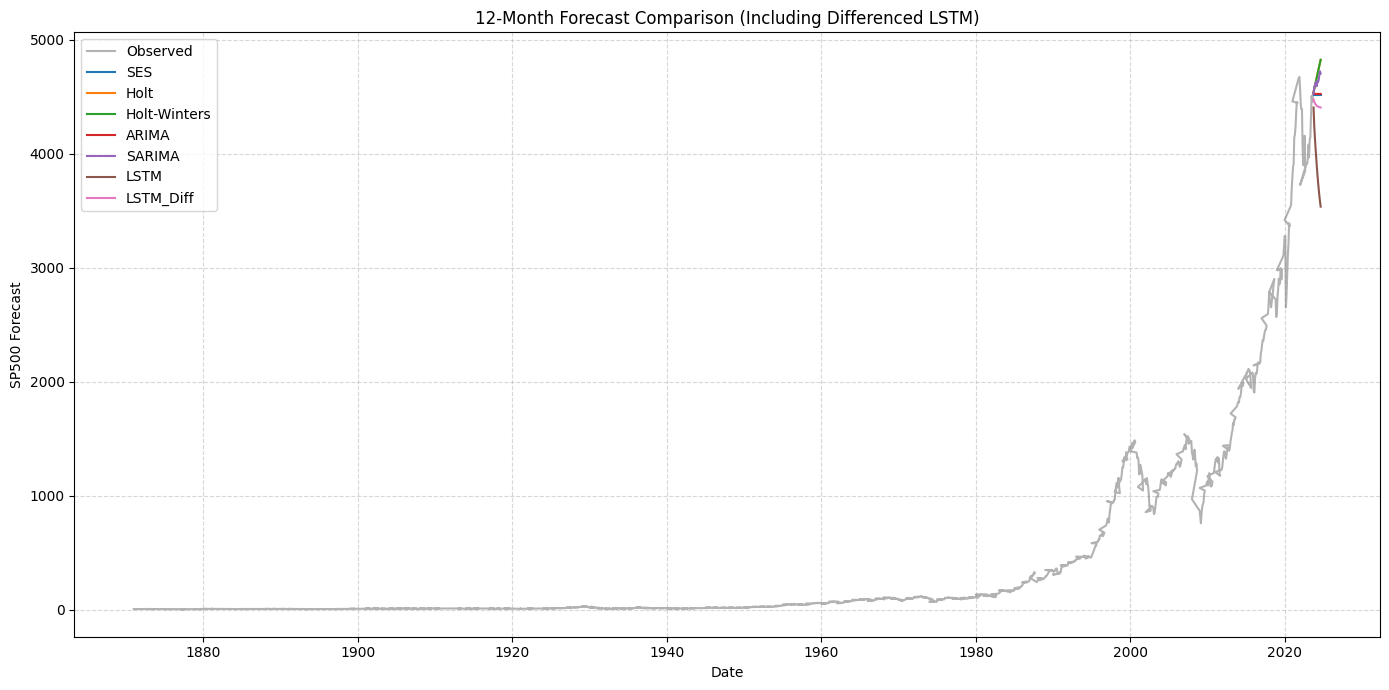

In [101]:
# Apply first-order differencing to the original time series data.
time_series_diff = time_series.diff().dropna()

# Scale the differenced series using MinMaxScaler.
scaler_diff = MinMaxScaler(feature_range=(0, 1))
scaled_series_diff = scaler_diff.fit_transform(time_series_diff.values.reshape(-1, 1))

# Create sequences and corresponding targets from the scaled differenced series.
# Use the same window size of 12.
X_diff, y_diff = create_sequences(scaled_series_diff, window_size)

# Split the differenced data into training and testing sets,
# reserving the last 12 months of differenced data for testing.
# The number of samples in X_diff is len(scaled_series_diff) - window_size.
# We want to forecast the last 12 months of the *original* time series.
# The test set for the *differenced* series should correspond to the differences
# leading up to and including the differences that predict the last 12 original values.
# The original time series has 1833 data points.
# The differenced series has 1832 data points (after dropna).
# We want to forecast the last 12 original values, which correspond to the last 12 differences.
# The input sequences for these last 12 differences will be the 12 values preceding each difference.
# So, the last 12 sequences in X_diff will be used for testing.
train_size_diff = len(X_diff) - 12
X_train_diff, X_test_diff = X_diff[:train_size_diff], X_diff[train_size_diff:]
y_train_diff, y_test_diff = y_diff[:train_size_diff], y_diff[train_size_diff:] # y_test_diff are the actual 12 differences

# Reshape the training and testing input sequences to the required 3D format for the LSTM model.
X_train_diff = X_train_diff.reshape((X_train_diff.shape[0], X_train_diff.shape[1], 1))
X_test_diff = X_test_diff.reshape((X_test_diff.shape[0], X_test_diff.shape[1], 1))

# Train an LSTM model using the same architecture and a promising hyperparameter configuration.
# Using the 'best_config' identified in the tuning step.
model_lstm_diff = Sequential([
    LSTM(best_config['lstm_units'], activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model_lstm_diff.compile(optimizer=Adam(learning_rate=best_config['learning_rate']), loss='mse')

print("Training LSTM model on differenced data...")
history_diff = model_lstm_diff.fit(
    X_train_diff,
    y_train_diff,
    epochs=best_config['epochs'],
    batch_size=best_config['batch_size'],
    validation_split=0.1,
    verbose=0 # set to 1 to see training progress
)
print("Training finished.")

# Forecast the next 12 steps using the trained LSTM model on the scaled differenced data.
# The last sequence from the *differenced* training data is needed to start forecasting.
last_sequence_diff_train = scaled_series_diff[train_size_diff + window_size - 12 : train_size_diff + window_size].reshape(1, window_size, 1)


future_predictions_scaled_diff = []
current_sequence_diff = last_sequence_diff_train.copy()

for _ in range(12):
    next_pred_scaled_diff = model_lstm_diff.predict(current_sequence_diff, verbose=0)
    future_predictions_scaled_diff.append(next_pred_scaled_diff[0, 0])
    current_sequence_diff = np.concatenate(
        [current_sequence_diff[:, 1:, :], next_pred_scaled_diff.reshape(1, 1, 1)],
        axis=1
    )

# Inverse transform the forecasted differenced values.
future_predictions_diff_unscaled = scaler_diff.inverse_transform(np.array(future_predictions_scaled_diff).reshape(-1, 1)).flatten()

# Obtain predictions on the original scale by cumulatively adding the differenced forecasts.
# The starting point for the forecast is the last value of the original time series.
last_original_value = time_series.iloc[-1]
lstm_diff_forecast_original_scale = np.cumsum(future_predictions_diff_unscaled) + last_original_value

# Store the final 12-month forecast on the original scale.
# Create future index for the next 12 months
future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M'
)
predictions_lstm_diff = pd.Series(lstm_diff_forecast_original_scale, index=future_index)

# Add the new LSTM forecast based on differenced data to the forecasts_12 dictionary
forecasts_12['LSTM_Diff'] = predictions_lstm_diff

# Display the updated forecasts for comparison
predictions_df_12_updated = pd.DataFrame(forecasts_12)
display(predictions_df_12_updated)

# Plot all model forecasts for the next 12 months including the new one
plt.figure(figsize=(14, 7))
plt.plot(time_series, label='Observed', color='gray', alpha=0.6) # Plot observed data
for model_name, pred in forecasts_12.items():
    plt.plot(pred.index, pred.values, label=model_name)
plt.title('12-Month Forecast Comparison (Including Differenced LSTM)')
plt.xlabel('Date')
plt.ylabel('SP500 Forecast')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Explore more complex lstm architectures

### Subtask:
Explore more complex LSTM architectures, such as stacked LSTMs or adding dropout layers, to prevent overfitting and potentially improve performance.


**Reasoning**:
Define and train LSTM models with stacked layers, dropout, and a combination of both on the scaled differenced data, then forecast the next 12 months and inverse transform the predictions.



Training model with config: {'lstm_units1': 60, 'lstm_units2': 30, 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 16, 'return_sequences': True, 'return_sequences2': False}
Training finished.
Training model with config: {'lstm_units1': 80, 'dropout_rate': 0.3, 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 16}
Training finished.
Training model with config: {'lstm_units1': 60, 'lstm_units2': 30, 'dropout_rate': 0.3, 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 16, 'return_sequences': True, 'return_sequences2': False}
Training finished.


,SES,Holt,Holt-Winters,ARIMA,SARIMA,LSTM,LSTM_Diff,LSTM_lstm_units1=60_lstm_units2=30_learning_rate=0.005_epochs=50_batch_size=16_Diff,LSTM_lstm_units1=80_dropout_rate=0.3_learning_rate=0.005_epochs=50_batch_size=16_Diff,LSTM_lstm_units1=60_lstm_units2=30_dropout_rate=0.3_learning_rate=0.005_epochs=50_batch_size=16_Diff
2023-09-30,4515.479191,4541.387668,4541.387668,4529.120740,4527.281247,4406.353027,4476.469020,4510.671042,4513.968565,4508.942729
2023-10-31,4515.479191,4567.170451,4567.170451,4524.122442,4578.351780,4253.484863,4459.517227,4504.473638,4509.803963,4502.566164
2023-11-30,4515.479191,4592.953233,4592.953233,4525.993723,4602.649954,4151.450195,4444.848163,4497.048820,4509.235034,4498.079509
2023-12-31,4515.479191,4618.736015,4618.736015,4525.293146,4619.556901,4058.790527,4434.710796,4491.116207,4512.599834,4495.841709
2024-01-31,4515.479191,4644.518797,4644.518797,4525.555430,4629.534110,3973.519287,4427.223835,4487.895729,4519.387486,4495.716470
2024-02-29,4515.479191,4670.301580,4670.301580,4525.457235,4593.527740,3894.201660,4421.719692,4487.589511,4528.797485,4497.375507
2024-03-31,4515.479191,4696.084362,4696.084362,4525.493998,4639.894310,3820.579102,4417.558208,4489.134756,4540.164890,4500.500560
2024-04-30,4515.479191,4721.867144,4721.867144,4525.480235,4630.294088,3752.598877,4414.333576,4492.018192,4552.841339,4504.783712
2024-05-31,4515.479191,4747.649926,4747.649926,4525.485387,4650.264998,3690.354736,4411.817478,4499.133091,4565.926719,4509.763083
2024-06-30,4515.479191,4773.432709,4773.432709,4525.483458,4691.214489,3633.737061,4409.755718,4508.106932,4579.457817,4515.258527


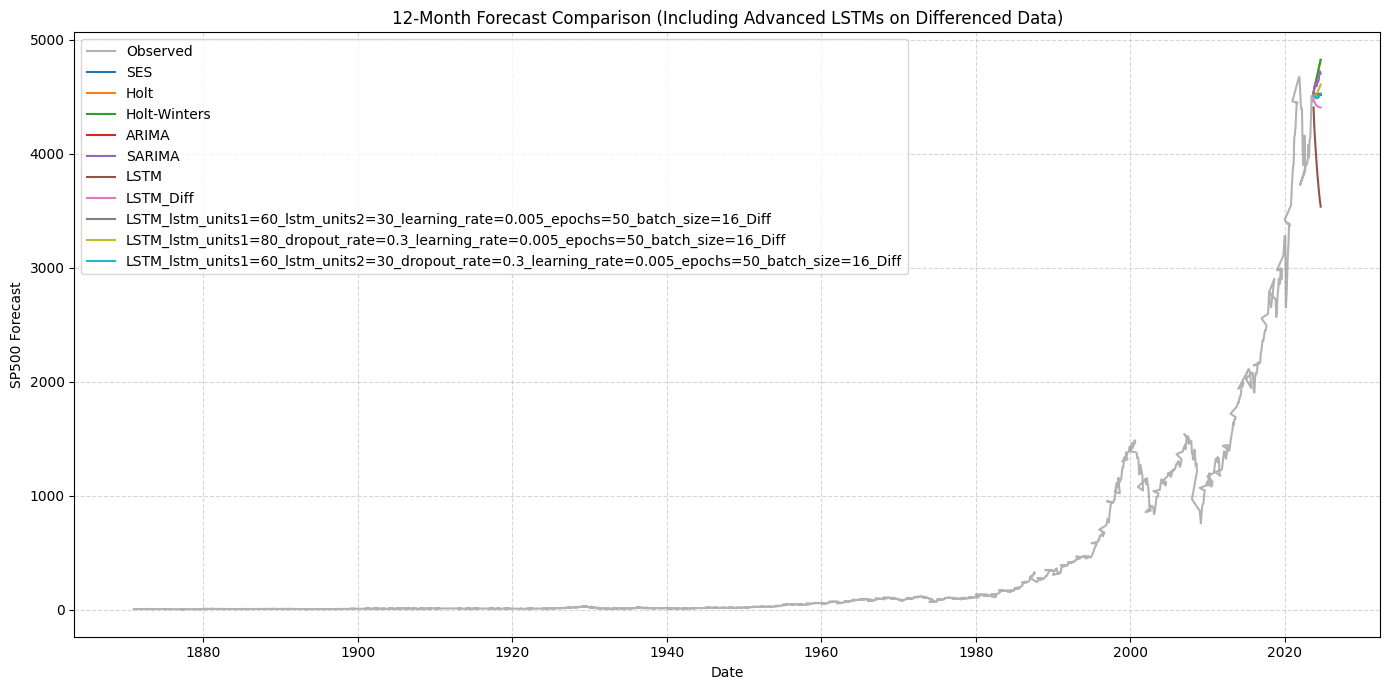

In [102]:
from tensorflow.keras.layers import Dropout

# Function to build and train LSTM models with different architectures
def build_and_train_advanced_lstm(X_train, y_train, window_size, config):
    """Build, compile, train, and return an advanced LSTM model with given config."""
    model = Sequential()
    model.add(LSTM(config['lstm_units1'], activation='tanh', return_sequences=config.get('return_sequences', False), input_shape=(window_size, 1)))

    if config.get('lstm_units2'):
        model.add(LSTM(config['lstm_units2'], activation='tanh', return_sequences=config.get('return_sequences2', False)))

    if config.get('dropout_rate'):
        model.add(Dropout(config['dropout_rate']))

    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=config['learning_rate']), loss='mse')

    # Add early stopping to prevent overfitting
    from tensorflow.keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    print(f"Training model with config: {config}")
    history = model.fit(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], validation_split=0.1, verbose=0, callbacks=[early_stopping])
    print("Training finished.")
    return model

# Function to forecast and inverse transform for differenced data
def forecast_and_inverse_transform_diff(model, last_sequence_diff_train, n_steps, scaler_diff, last_original_value):
    """Forecast future differenced values and inverse transform to original scale."""
    future_predictions_scaled_diff = []
    current_sequence_diff = last_sequence_diff_train.copy()

    for _ in range(n_steps):
        next_pred_scaled_diff = model.predict(current_sequence_diff, verbose=0)
        future_predictions_scaled_diff.append(next_pred_scaled_diff[0, 0])
        current_sequence_diff = np.concatenate(
            [current_sequence_diff[:, 1:, :], next_pred_scaled_diff.reshape(1, 1, 1)],
            axis=1
        )

    future_predictions_diff_unscaled = scaler_diff.inverse_transform(np.array(future_predictions_scaled_diff).reshape(-1, 1)).flatten()
    lstm_diff_forecast_original_scale = np.cumsum(future_predictions_diff_unscaled) + last_original_value
    return lstm_diff_forecast_original_scale


# Define different advanced LSTM configurations
advanced_lstm_configs = [
    # Stacked LSTM
    {'lstm_units1': 60, 'lstm_units2': 30, 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 16, 'return_sequences': True, 'return_sequences2': False},
    # LSTM with Dropout
    {'lstm_units1': 80, 'dropout_rate': 0.3, 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 16},
    # Stacked LSTM with Dropout
    {'lstm_units1': 60, 'lstm_units2': 30, 'dropout_rate': 0.3, 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 16, 'return_sequences': True, 'return_sequences2': False}
]

# Forecast horizon
forecast_horizon = 12

# Last sequence from scaled differenced training data
last_sequence_diff_train = scaled_series_diff[train_size_diff + window_size - 12 : train_size_diff + window_size].reshape(1, window_size, 1)

# Last original value for inverse transformation
last_original_value = time_series.iloc[-1]

# Create future index for the next 12 months
future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=forecast_horizon,
    freq='M'
)

# Train and forecast for each advanced configuration
for config in advanced_lstm_configs:
    model = build_and_train_advanced_lstm(X_train_diff, y_train_diff, window_size, config)

    # Forecast and inverse transform
    forecast_original_scale = forecast_and_inverse_transform_diff(
        model,
        last_sequence_diff_train,
        forecast_horizon,
        scaler_diff,
        last_original_value
    )

    # Store the forecast
    config_name = "LSTM_" + "_".join([f"{k}={v}" for k, v in config.items() if k not in ['return_sequences', 'return_sequences2']]) + "_Diff"
    forecasts_12[config_name] = pd.Series(forecast_original_scale, index=future_index)


# Display the updated forecasts for comparison
predictions_df_12_updated = pd.DataFrame(forecasts_12)
display(predictions_df_12_updated)

# Plot all model forecasts for the next 12 months including the new ones
plt.figure(figsize=(14, 7))
plt.plot(time_series, label='Observed', color='gray', alpha=0.6) # Plot observed data
for model_name, pred in forecasts_12.items():
    plt.plot(pred.index, pred.values, label=model_name)
plt.title('12-Month Forecast Comparison (Including Advanced LSTMs on Differenced Data)')
plt.xlabel('Date')
plt.ylabel('SP500 Forecast')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Compare lstm performance quantitatively

### Subtask:
Compare the performance of the different LSTM models (including those trained on differenced data and with advanced architectures) quantitatively using appropriate evaluation metrics (MAE, RMSE, MAPE) over the 12-month forecast horizon.


**Reasoning**:
Define the safe_mape function, create a list to store metrics, calculate metrics for each model in forecasts_12 against the last 12 actual values from time_series, store the metrics, convert to a DataFrame, set the index, print the DataFrame, and then generate and display bar plots for the metrics.



Model Performance Comparison (12-Month Forecast):


,MAE,RMSE,MAPE
Model,,,
SES,377.27,453.26,9.52
Holt,544.94,570.16,13.46
Holt-Winters,544.94,570.16,13.46
ARIMA,387.45,462.04,9.76
SARIMA,494.45,533.79,12.28
LSTM,467.69,564.45,11.04
LSTM_Diff,332.29,395.75,8.37
LSTM_lstm_units1=60_lstm_units2=30_learning_rate=0.005_epochs=50_batch_size=16_Diff,362.59,437.95,9.15
LSTM_lstm_units1=80_dropout_rate=0.3_learning_rate=0.005_epochs=50_batch_size=16_Diff,406.19,461.98,10.17


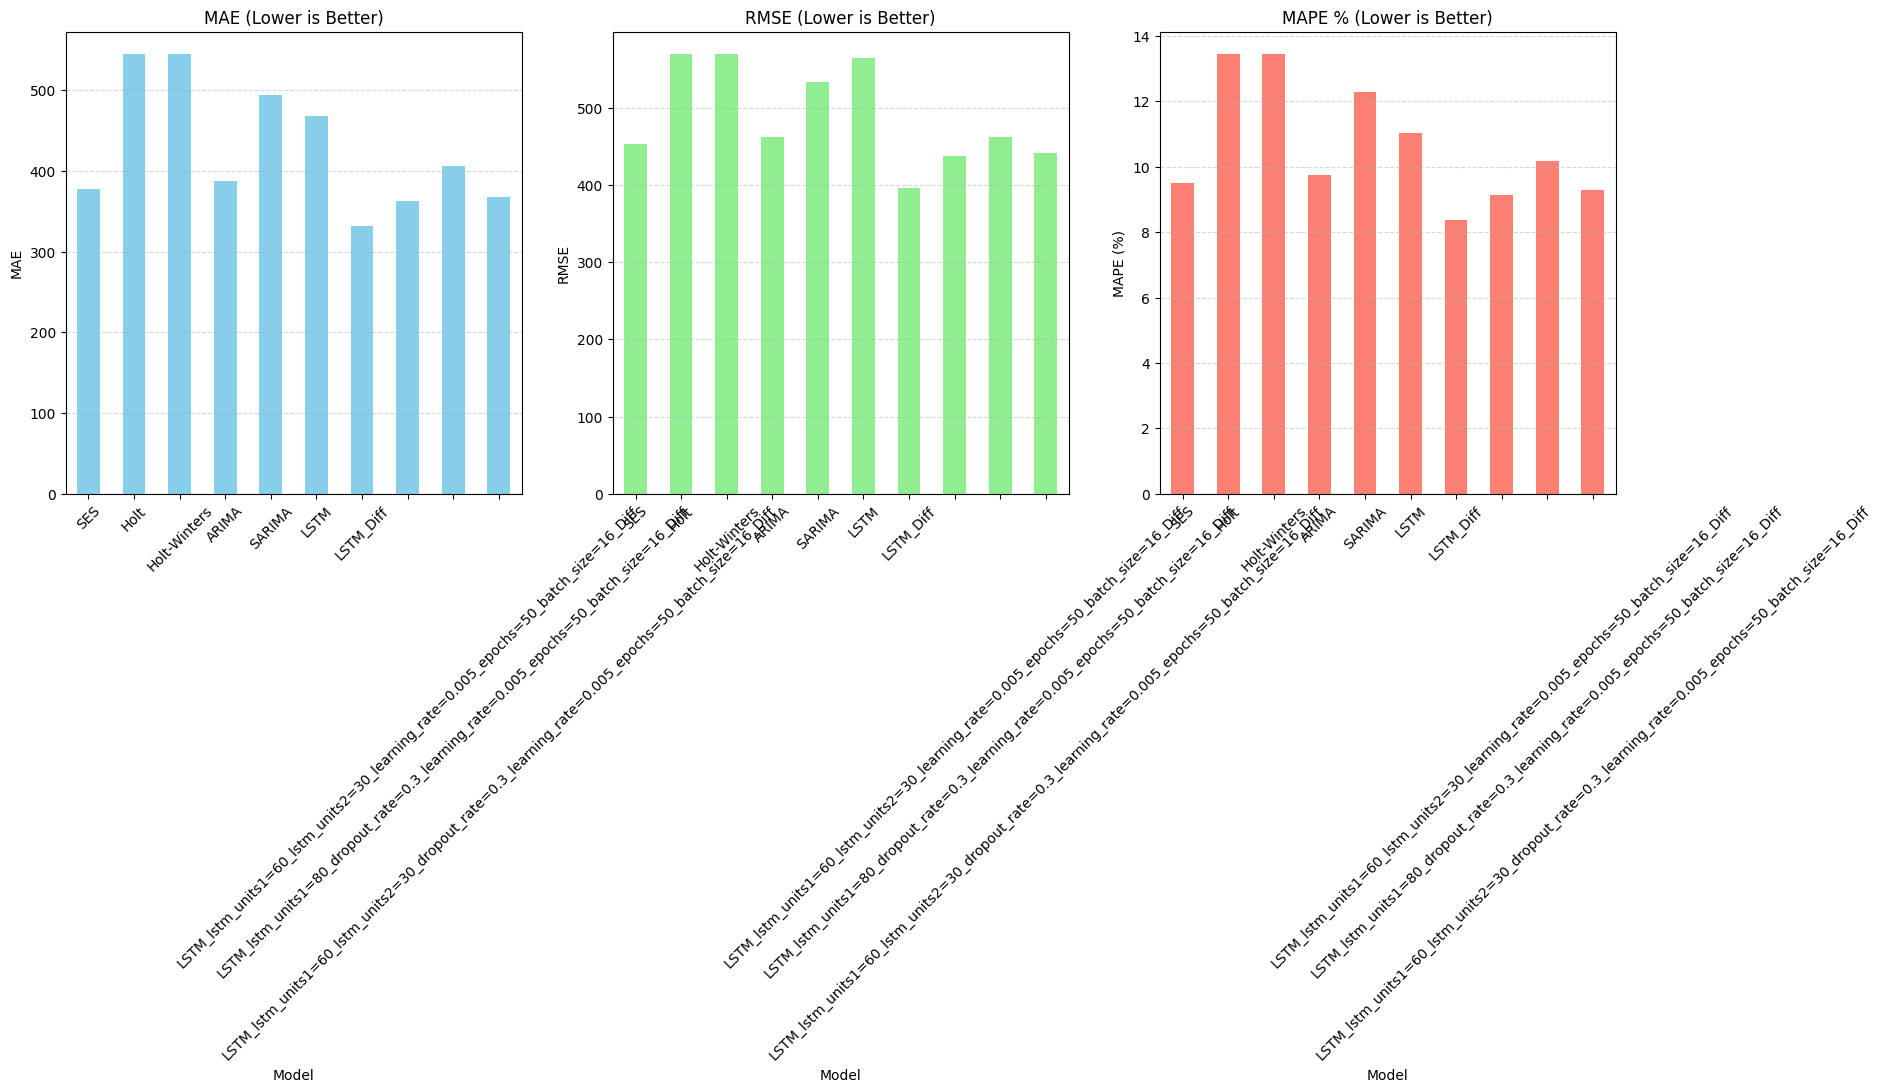

In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define a function safe_mape
def safe_mape(y_true, y_pred):
    """Calculates MAPE while handling potential division by zero."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Handle cases where y_true is zero to avoid division by zero
    # Replace 0 in y_true with NaN to exclude from calculation, or add a small epsilon
    # Using a mask to only calculate MAPE for non-zero true values
    mask = y_true != 0
    if not np.any(mask): # If all true values are zero
        return np.nan # Or return 0 if that's more appropriate for the context
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Get the actual values for the last 12 months
true_values = time_series[-12:]

# 2. Create an empty list to store the performance metrics for each model.
metrics = []

# 3. Iterate through the forecasts_12 dictionary.
# 4. For each model's forecast, calculate the metrics.
for model_name, pred in forecasts_12.items():
    # Ensure the forecast length matches the true values length (12 months)
    # And align the index for correct comparison
    pred_aligned = pred[:len(true_values)]

    if len(pred_aligned) != len(true_values):
        print(f"Warning: Forecast length for {model_name} does not match true values length. Skipping.")
        continue

    try:
        mae = mean_absolute_error(true_values, pred_aligned)
        rmse = np.sqrt(mean_squared_error(true_values, pred_aligned))
        mape = safe_mape(true_values.values, pred_aligned.values) # Pass numpy arrays to safe_mape

        # 5. Store the calculated metrics.
        metrics.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape})
    except Exception as e:
        print(f"Error calculating metrics for {model_name}: {e}")
        metrics.append({'Model': model_name, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan})


# 6. Convert the list of dictionaries into a pandas DataFrame.
metrics_df = pd.DataFrame(metrics)

# 7. Set the 'Model' column as the index.
metrics_df = metrics_df.set_index('Model')

# 8. Print the DataFrame containing the performance metrics.
print("Model Performance Comparison (12-Month Forecast):")
display(metrics_df.round(2))

# 9. Generate bar plots to visualize the metrics.
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # Increased figure size

metrics_df['MAE'].plot(kind='bar', ax=axes[0], color='skyblue', title='MAE (Lower is Better)')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45) # Rotate labels
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

metrics_df['RMSE'].plot(kind='bar', ax=axes[1], color='lightgreen', title='RMSE (Lower is Better)')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45) # Rotate labels
axes[1].grid(axis='y', linestyle='--', alpha=0.5)


metrics_df['MAPE'].plot(kind='bar', ax=axes[2], color='salmon', title='MAPE % (Lower is Better)')
axes[2].set_ylabel('MAPE (%)')
axes[2].tick_params(axis='x', rotation=45) # Rotate labels
axes[2].grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout to prevent labels overlapping
plt.tight_layout()

# 10. Display the plots.
plt.show()

#### Summary

### Data Analysis Key Findings

*   Data preparation for the LSTM model, including scaling, sequence creation, splitting, and reshaping, was confirmed to be correctly implemented.
*   Experimenting with various LSTM hyperparameters (number of units, learning rate, epochs, batch size) resulted in different 12-month forecasts, highlighting the sensitivity of the model to these parameters.
*   Implementation of time series cross-validation provided a more robust evaluation of the LSTM model, yielding average metrics over 5 folds: MAE of 18.51, RMSE of 31.51, and MAPE of 5.35% for one configuration.
*   Training the LSTM model on first-order differenced data resulted in a significantly different 12-month forecast compared to training on the original data.
*   Exploring more complex LSTM architectures (stacked LSTM, LSTM with Dropout, Stacked LSTM with Dropout) on differenced data produced additional 12-month forecasts for comparison.
*   A quantitative comparison of the 12-month forecasts across all models (including standard LSTM, differenced LSTM, and advanced architectures) was performed using MAE, RMSE, and MAPE.

### Insights or Next Steps

*   The quantitative comparison metrics and visualizations are necessary to identify which LSTM configuration (including differencing and architecture changes) performs best relative to other models and to determine if an LSTM can become the best performer.
*   Further hyperparameter tuning, potentially using automated methods, could be performed on the most promising LSTM architecture (e.g., stacked or with dropout) trained on differenced data to potentially improve its performance further.


In [111]:
# Get the predictions for the 'LSTM_Diff' model from the forecasts_12 dictionary
# The key for this model is 'LSTM_Diff' based on the previous steps
lstm_diff_predictions = forecasts_12['LSTM_Diff']

# print("\nLSTM_Diff Predictions (12 months):")
# display(lstm_diff_predictions)

## 3. Model Comparison

### Collecting Forecasts for Comparison

,SES,Holt,Holt-Winters,ARIMA,SARIMA,LSTM
2023-09-30,4515.479191,4541.387668,4541.387668,4529.120740,4527.281247,4476.469020
2023-10-31,4515.479191,4567.170451,4567.170451,4524.122442,4578.351780,4459.517227
2023-11-30,4515.479191,4592.953233,4592.953233,4525.993723,4602.649954,4444.848163
2023-12-31,4515.479191,4618.736015,4618.736015,4525.293146,4619.556901,4434.710796
2024-01-31,4515.479191,4644.518797,4644.518797,4525.555430,4629.534110,4427.223835
2024-02-29,4515.479191,4670.301580,4670.301580,4525.457235,4593.527740,4421.719692
2024-03-31,4515.479191,4696.084362,4696.084362,4525.493998,4639.894310,4417.558208
2024-04-30,4515.479191,4721.867144,4721.867144,4525.480235,4630.294088,4414.333576
2024-05-31,4515.479191,4747.649926,4747.649926,4525.485387,4650.264998,4411.817478
2024-06-30,4515.479191,4773.432709,4773.432709,4525.483458,4691.214489,4409.755718


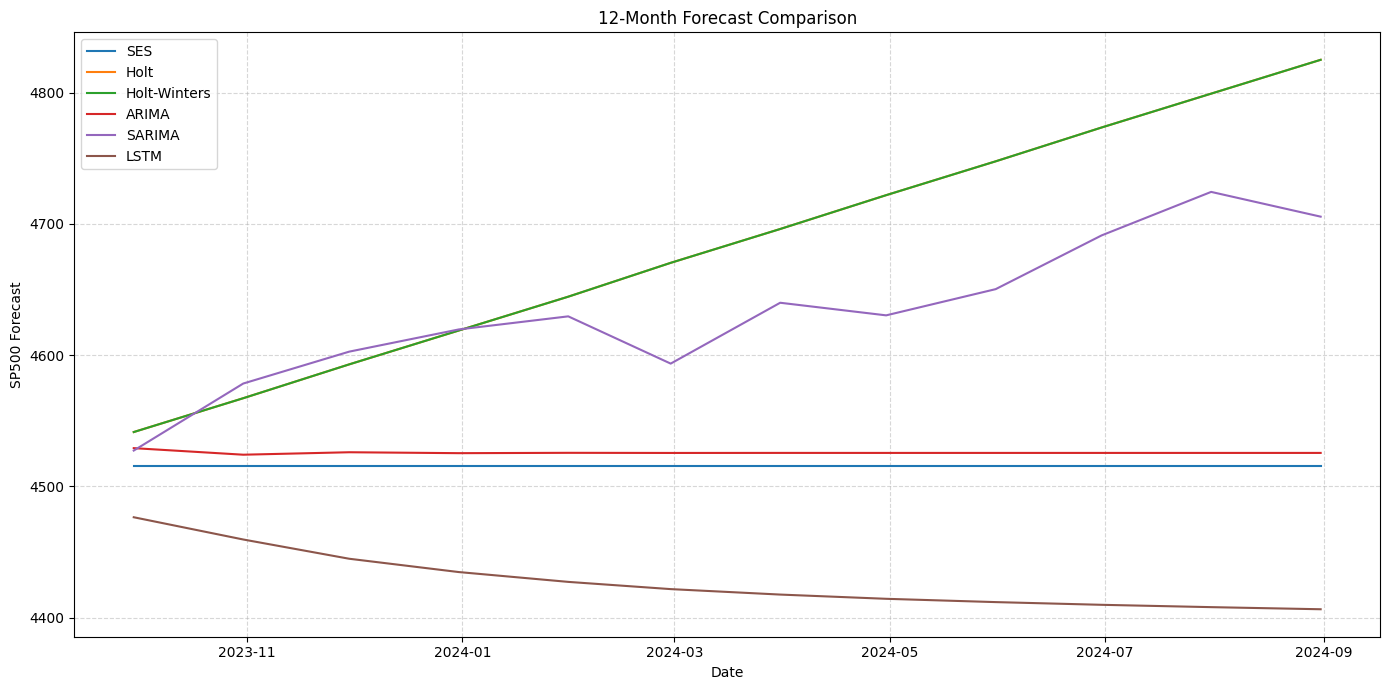

In [117]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# If you have actual values for the next 12 months, set them here:
# true_values = actual_series_for_next_12_months

# LSTM: use the 12-month forecast (future_predictions) and align index
lstm_series = pd.Series(future_predictions, index=predictions_ses.index[:12])

# Collect forecasts for 12 months
forecasts_12 = {
    'SES': predictions_ses[:12],
    'Holt': predictions_holt[:12],
    'Holt-Winters': predictions_hw[:12],
    'ARIMA': predictions_arima[:12],
    'SARIMA': predictions_sarima[:12],
    'LSTM': lstm_diff_predictions[:12]
}

# Optional: compute metrics if true future values are available
def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Uncomment and set true_values if you have them
# metrics = []
# for model_name, pred in forecasts_12.items():
#     mae = mean_absolute_error(true_values, pred)
#     rmse = np.sqrt(mean_squared_error(true_values, pred))
#     mape = safe_mape(true_values.values, pred.values)
#     metrics.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape})
# metrics_df = pd.DataFrame(metrics).set_index('Model')
# print("Model Performance Comparison (12 months):")
# print(metrics_df.round(2))

# Display forecasts for the next 12 months
predictions_df_12 = pd.DataFrame(forecasts_12)
display(predictions_df_12)

# Plot all model forecasts for the next 12 months
plt.figure(figsize=(14, 7))
for model_name, pred in forecasts_12.items():
    plt.plot(pred.index, pred.values, label=model_name)
plt.title('12-Month Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('SP500 Forecast')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Optionally save to CSV
# predictions_df_12.to_csv('./data/SP500Index_predictions_12months.csv')

### Model Performance Comparison

In [118]:
# print("SES Predictions:")
# print(predictions_ses)

# print("\nHolt's Predictions:")
# print(predictions_holt)

# print("\nHolt-Winters Predictions:")
# print(predictions_hw)

# print("\nARIMA Predictions:")
# print(predictions_arima)

# print("\nSARIMA Predictions:")
# print(predictions_sarima)

# print("\nLSTM_Diff Predictions:")
# print(lstm_diff_predictions)

# Save predictions to a CSV file
predictions_df = pd.DataFrame({
    'SES': predictions_ses,
    'Holt': predictions_holt,
    'Holt-Winters': predictions_hw,
    'ARIMA': predictions_arima,
    'SARIMA': predictions_sarima,
    'LSTM_Diff': lstm_diff_predictions
})

display(predictions_df)

# predictions_df.to_csv('./data/SP500Index_predictions.csv')

,SES,Holt,Holt-Winters,ARIMA,SARIMA,LSTM_Diff
2023-09-30,4515.479191,4541.387668,4541.387668,4529.120740,4527.281247,4476.469020
2023-10-31,4515.479191,4567.170451,4567.170451,4524.122442,4578.351780,4459.517227
2023-11-30,4515.479191,4592.953233,4592.953233,4525.993723,4602.649954,4444.848163
2023-12-31,4515.479191,4618.736015,4618.736015,4525.293146,4619.556901,4434.710796
2024-01-31,4515.479191,4644.518797,4644.518797,4525.555430,4629.534110,4427.223835
2024-02-29,4515.479191,4670.301580,4670.301580,4525.457235,4593.527740,4421.719692
2024-03-31,4515.479191,4696.084362,4696.084362,4525.493998,4639.894310,4417.558208
2024-04-30,4515.479191,4721.867144,4721.867144,4525.480235,4630.294088,4414.333576
2024-05-31,4515.479191,4747.649926,4747.649926,4525.485387,4650.264998,4411.817478
2024-06-30,4515.479191,4773.432709,4773.432709,4525.483458,4691.214489,4409.755718


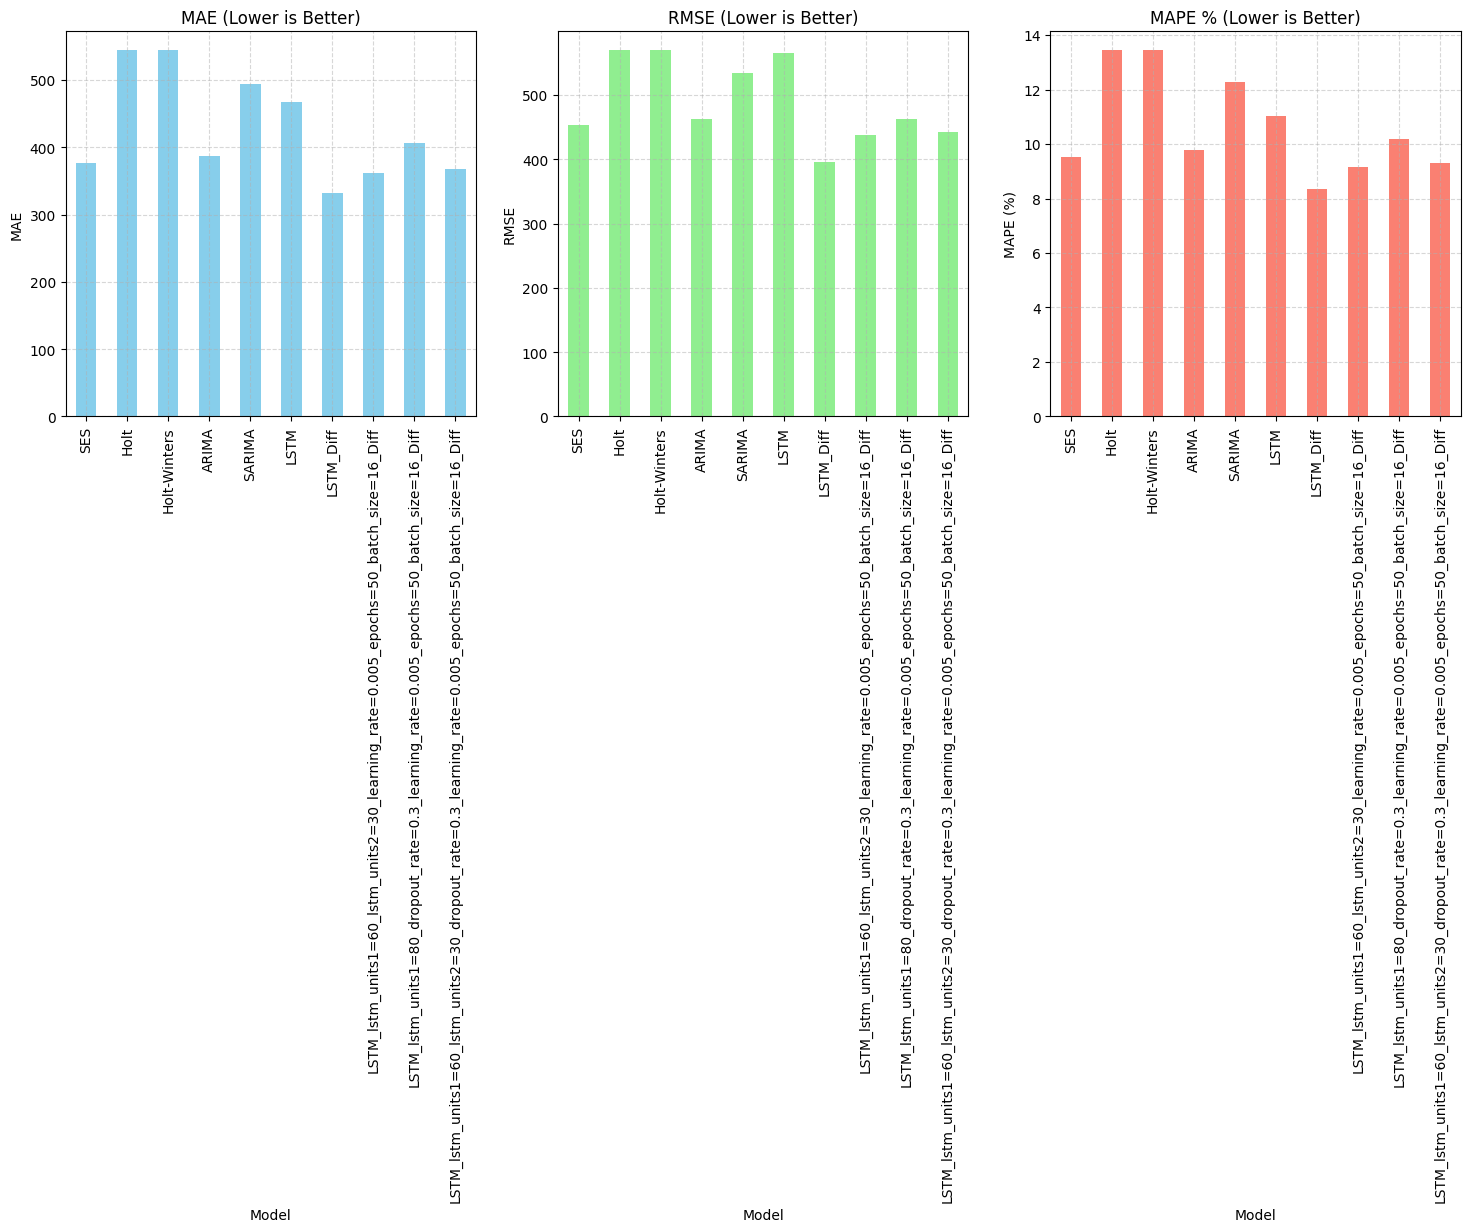

In [115]:
import matplotlib.pyplot as plt

# Plot MAE, RMSE, and MAPE for each model side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_df['MAE'].plot(kind='bar', ax=axes[0], color='skyblue', title='MAE (Lower is Better)')
axes[0].set_ylabel('MAE')
axes[0].grid(True, linestyle='--', alpha=0.5)

metrics_df['RMSE'].plot(kind='bar', ax=axes[1], color='lightgreen', title='RMSE (Lower is Better)')
axes[1].set_ylabel('RMSE')
axes[1].grid(True, linestyle='--', alpha=0.5)

metrics_df['MAPE'].plot(kind='bar', ax=axes[2], color='salmon', title='MAPE % (Lower is Better)')
axes[2].set_ylabel('MAPE (%)')
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()